# Plant Health AI Assistant - Runtime with Memory
## Overview
This notebook demonstrates how to deploy a LangGraph-based plant health analysis system with persistent memory capabilities using AWS Bedrock AgentCore. The system combines multi-agent orchestration with memory storage to provide intelligent plant diagnosis and historical tracking.

# Key Components
1. Multi-Agent LangGraph Workflow
Entry Router: Determines if query is for analysis or history retrieval

Plant Detection Agent: Identifies plant type and health issues

Care Agent: Provides expert treatment advice

Web Search Agent: Finds latest research and recommendations

Memory Agents: Save and retrieve plant analysis history

2. AWS Bedrock AgentCore Memory
Persistent storage for plant analysis sessions

Actor-based memory isolation (farmer-specific)

30-day retention for plant health tracking

Conversation-style memory format

3. Docker Deployment
ARM64 container for AWS optimization

Serverless scaling through AgentCore Runtime

Production-ready with monitoring and error handling

Prerequisites
AWS Account with Bedrock AgentCore access

Completed MCP Gateway setup (from previous notebook)

Docker and AWS CLI configured

Python 3.10+ environment

# 01. Install dependencies and configure clients 

In [ ]:
!pip install -q -r requirements.txt --no-cache-dir

print("✅ Requirements installed. Now run the cells below.")

In [ ]:
#restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
import boto3
from botocore.exceptions import ClientError
import json
import sys
import os
import time
import logging
from datetime import datetime
from typing import List, TypedDict, Any, Annotated
import base64
import random
import string
import shutil
import uuid
from PIL import Image
import io


from utils.utils import create_agentcore_role, create_agentcore_mem_role

from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
 
from bedrock_agentcore.runtime import BedrockAgentCoreApp
from bedrock_agentcore.memory import MemoryClient
from bedrock_agentcore_starter_toolkit.operations.gateway.client import GatewayClient
from bedrock_agentcore_starter_toolkit.notebook import Runtime

# Add this at the top of your notebook
import nest_asyncio
nest_asyncio.apply()


# Core clients and variables
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]
region = boto3.session.Session().region_name
suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=8))

iam_client = boto3.client('iam')

## Load notebook 01 configuration

In [2]:
try:
    with open('plant_gateway_config.json', 'r') as f:
        config = json.load(f)
        
    REGION = config['REGION']
    GATEWAY_ID = config['GATEWAY_ID']
    MCP_URL = config['GATEWAY_URL']
    COGNITO_INFO = config['COGNITO_INFO']
    
    print(f"Gateway ID: {GATEWAY_ID}")
    print(f"Gateway URL: {MCP_URL}")
    print(f"Region: {REGION}")
    print("✅ Configuration loaded successfully!")
    
except FileNotFoundError:
    print("❌ Config file not found. Run the setup notebook first!")

Gateway ID: testgateway57d9311d-zt0hvuzzjv
Gateway URL: https://testgateway57d9311d-zt0hvuzzjv.gateway.bedrock-agentcore.us-west-2.amazonaws.com/mcp
Region: us-west-2
✅ Configuration loaded successfully!


In [3]:
# setup the gateway client
gateway_client = GatewayClient(region_name=REGION)

# setup memory client
memory_client = MemoryClient(region_name=REGION)

# Get access token
access_token = gateway_client.get_access_token_for_cognito(COGNITO_INFO)

2025-08-07 21:23:48,738 - bedrock_agentcore.gateway - INFO - Fetching test token from Cognito...
2025-08-07 21:23:48,739 - bedrock_agentcore.gateway - INFO -   Attempting to connect to token endpoint: https://agentcore-1782cdd6.auth.us-west-2.amazoncognito.com/oauth2/token
2025-08-07 21:23:49,107 - bedrock_agentcore.gateway - INFO - ✓ Got test token successfully


# Create AgentCore Runtime and AgentCore Memory roles

In [4]:
agent_name = "plant-advisor-agent-langgraph"
agentcore_iam_role = create_agentcore_role(agent_name=agent_name)

print(f"Runtime agent role: {agentcore_iam_role}")
print("✅ Runtime agent role successfully created!")

agentcore_mem_name = "plant-advisor-mem-langgraph"
MEMORY_ROLE_ARN = create_agentcore_mem_role(agentcore_mem_name)

print(f"Memory agent role: {agentcore_iam_role}")
print("✅ Memory agent role successfully created!")

Role already exists -- deleting and creating it again
  Detaching: AmazonBedrockAgentCoreMemoryBedrockModelInferenceExecutionRolePolicy
policies: {'PolicyNames': [], 'IsTruncated': False, 'ResponseMetadata': {'RequestId': 'd3ed4d6a-0c59-4b59-8450-4f3a2580b283', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 07 Aug 2025 21:23:53 GMT', 'x-amzn-requestid': 'd3ed4d6a-0c59-4b59-8450-4f3a2580b283', 'content-type': 'text/xml', 'content-length': '323'}, 'RetryAttempts': 0}}
deleting agentcore-plant-advisor-agent-langgraph-role
recreating agentcore-plant-advisor-agent-langgraph-role
attaching role policy agentcore-plant-advisor-agent-langgraph-role
Runtime agent role: {'Role': {'Path': '/', 'RoleName': 'agentcore-plant-advisor-agent-langgraph-role', 'RoleId': 'AROAYUMA2YYGD5K3LQGVO', 'Arn': 'arn:aws:iam::593512547852:role/agentcore-plant-advisor-agent-langgraph-role', 'CreateDate': datetime.datetime(2025, 8, 7, 21, 23, 53, tzinfo=tzlocal()), 'AssumeRolePolicyDocument': {'Version': '2012-1

# Update configuration with Memory role and name for reuse 

In [5]:
# Create unique memory name with timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
unique_memory_name = f"PlantHealthAdvisor_{timestamp}"

# Load existing config
try:
    with open('plant_gateway_config.json', 'r') as f:
        config = json.load(f)
    
    # Add memory role ARN
    config['MEMORY_ROLE_ARN'] = MEMORY_ROLE_ARN
    config['MEMORY_NAME'] = unique_memory_name
    
    # Write updated config
    with open('plant_gateway_config.json', 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"✅ Added MEMORY_ROLE_ARN to config: {MEMORY_ROLE_ARN}")
    print(f"   MEMORY_NAME: {unique_memory_name}")
except Exception as e:
    print(f"❌ Failed to update config: {e}")


✅ Added MEMORY_ROLE_ARN to config: arn:aws:iam::593512547852:role/agentcore-mem-plant-advisor-mem-langgraph-role
   MEMORY_NAME: PlantHealthAdvisor_20250807212402


# Create Memory Store

In [6]:
memory_id = None

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
logger = logging.getLogger("agentcore-memory")

ACTOR_ID = "user_123"
SESSION_ID = "plant_analysis_session_001"  # Reuse same session for continuity

#Create Memory Store
try:
    print("Creating Memory...")
    memory = memory_client.create_memory_and_wait(
        name=unique_memory_name,
        description="Plant Health Analysis Memory",
        strategies=[],  # No strategies for short-term memory
        event_expiry_days=30,  # Keep plant analyses for 30 days
        memory_execution_role_arn=MEMORY_ROLE_ARN,
        max_wait=300,
        poll_interval=10
    )
    
    memory_id = memory['memoryId']
    print(f"✅ Memory created successfully with ID: {memory_id}")
    
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException' and "already exists" in str(e):
        # Memory exists, get its ID
        memories = memory_client.list_memories()
        memory_id = next((m['id'] for m in memories if m['id'].startswith(memory_name)), None)
        print(f"✅ Memory already exists. Using existing memory ID: {memory_id}")
    else:
        print(f"❌ Memory creation error: {e}")
        
except Exception as e:
    print(f"❌ ERROR: {e}")

Creating Memory...


2025-08-07 21:24:09 - INFO - Created memory: PlantHealthAdvisor_20250807212402-uJK0Ab7j72
2025-08-07 21:24:09 - INFO - Created memory PlantHealthAdvisor_20250807212402-uJK0Ab7j72, waiting for ACTIVE status...
2025-08-07 21:24:09 - INFO - Memory PlantHealthAdvisor_20250807212402-uJK0Ab7j72 is now ACTIVE (took 0 seconds)


✅ Memory created successfully with ID: PlantHealthAdvisor_20250807212402-uJK0Ab7j72


# Langgraph definition and Prep Agent Runtime

In [7]:
# Initialize AgentCore App
app = BedrockAgentCoreApp()

In [8]:
def parse_mcp_response(result):
    """Parse nested MCP response"""
    try:
        if 'result' in result and 'content' in result['result']:
            content = result['result']['content'][0]['text']
            outer_json = json.loads(content)
            if 'response' in outer_json and 'payload' in outer_json['response']:
                body = outer_json['response']['payload']['body']
                return json.loads(body)
        return None
    except Exception as e:
        print(f"Parse error: {e}")
        return None

In [9]:
class PlantAnalysisState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    prompt: str           # Add user query
    query_type: str       # Add query type: "analysis" or "history"
    image_path: str
    image_data: str
    plant_detection: dict
    health_issues: str
    expert_advice: str
    web_search_results: str
    final_report: str
    memory_status: str    # Add memory operation status

print("✅ Updated state definition with memory fields")


✅ Updated state definition with memory fields


In [10]:
def call_mcp_tool(tool_name: str, arguments: dict, bearer_token: str):
    """Generic MCP tool caller"""
    headers = {'Content-Type': 'application/json', 'Authorization': f'Bearer {bearer_token}'}
    payload = {
        "jsonrpc": "2.0",
        "id": 3,
        "method": "tools/call",
        "params": {"name": tool_name, "arguments": arguments}
    }
    response = requests.post(MCP_URL, headers=headers, json=payload)
    return response.json()

In [11]:
def create_plant_workflow():
    """Create plant analysis workflow using all three MCP tools + memory"""
    workflow = StateGraph(PlantAnalysisState)
    
    # Keep ALL your existing functions exactly as they are
    def detect_plant(state: PlantAnalysisState) -> dict:
        """Plant detection using MCP gateway tool"""
        bearer_token = gateway_client.get_access_token_for_cognito(COGNITO_INFO)
        image_path = state.get('image_path', '')
        image_data = state.get('image_data', '')
        print(f"🔍 Starting plant detection for: {image_path}")

        try: 
            if image_data:
                print(f"✅ Using provided image_data: {len(image_data)} characters")
                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {
                    "image_data": image_data
                }, bearer_token)
            elif image_path and not image_path.startswith('s3://') and image_path != "from_image_data":
                if not os.path.exists(image_path):
                    print(f"❌ Image file not found: {image_path}")
                    return {"plant_detection": {"plant_type": "error"}, "health_issues": "Image file not found"}

                with open(image_path, 'rb') as f:
                    image_bytes = f.read()
                    image_data_encoded = base64.b64encode(image_bytes).decode('utf-8')
                    print(f"✅ Image encoded: {len(image_data_encoded)} characters")

                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {
                    "image_data": image_data_encoded
                }, bearer_token)
            else:
                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {
                    "image_path": image_path
                }, bearer_token)

            parsed_result = parse_mcp_response(result)

            if parsed_result:
                plant_name = parsed_result.get("plant_name", "unknown")
                health_issues = parsed_result.get("health_issues", "")
                print(f"✅ Plant detected: {plant_name}")
                print(f"📋 Health status: {health_issues}")

                return {
                    "plant_detection": {"plant_type": plant_name},
                    "health_issues": health_issues
                }
        except Exception as e:
            print(f"❌ Plant detection error: {e}")

        return {"plant_detection": {"plant_type": "error"}, "health_issues": "Detection failed"}


    # Fix for entry_router function - make it return a dict
    def entry_router(state: PlantAnalysisState) -> dict:
        """Route based on query type - history or plant analysis"""
        prompt = state.get("prompt", "")
        image_data = state.get("image_data", "")
        image_path = state.get("image_path", "")
        
        # Check for history keywords
        if prompt:
            history_keywords = ["show me", "previous", "compare", "history", "analyses", "month", "last time"]
            if any(keyword in prompt.lower() for keyword in history_keywords):
                return {"next": "retrieve_memory"}
        
        # If has image data, go to plant detection
        if image_data or image_path:
            return {"next": "detect_plant"}
        
        return {"next": "END"}

    # Keep your ORIGINAL router for analysis routing
    def analysis_router(state: PlantAnalysisState) -> str:
        """Route based on plant detection results - your original logic"""
        plant_detection = state.get("plant_detection", {})
        plant_name = plant_detection.get("plant_type", "").lower()
        health_issues = state.get("health_issues", "").lower()
        
        if not plant_name or plant_name == "error":
            return "END"
        
        # Check for critical issues
        critical_keywords = ["severe", "dying", "critical", "emergency"]
        if any(keyword in health_issues for keyword in critical_keywords):
            return "urgent_consultation"
        
        return "expert_consultation"

    # Keep all your existing functions unchanged
    def plant_care_agent(state: PlantAnalysisState) -> dict:
        """Plant care using MCP gateway tool"""
        bearer_token = gateway_client.get_access_token_for_cognito(COGNITO_INFO)
        plant_info = state.get('plant_detection', {})
        health_status = state.get('health_issues', '')
        plant_name = plant_info.get('plant_type', 'unknown plant')
        
        print(f"🌱 Getting care advice for: {plant_name}")
        print(f"📋 Health status: {health_status}")
        
        try:
            result = call_mcp_tool("plant-care-target___plant_care_tool", {
                "plant_name": plant_name,
                "health_status": health_status
            }, bearer_token)
            
            parsed_result = parse_mcp_response(result)
            
            if parsed_result and 'expert_advice' in parsed_result:
                advice = parsed_result['expert_advice']
                print(f"✅ Care advice received ({len(advice)} chars)")
                return {'expert_advice': advice}
                
        except Exception as e:
            print(f"❌ Plant care error: {e}")
        
        return {'expert_advice': 'Plant care advice unavailable'}

    def web_search_agent(state: PlantAnalysisState) -> dict:
        """Web search using MCP gateway tool"""
        bearer_token = gateway_client.get_access_token_for_cognito(COGNITO_INFO)
        plant_info = state.get('plant_detection', {})
        health_status = state.get('health_issues', '')
        plant_name = plant_info.get('plant_type', 'unknown plant')
        
        print(f"🔍 Web searching for: {plant_name}")
        
        try:
            result = call_mcp_tool("plant-web-search-target___plant_web_search_tool", {
                "plant_name": plant_name,
                "health_status": health_status
            }, bearer_token)
            
            parsed_result = parse_mcp_response(result)
            
            if parsed_result:
                search_results = parsed_result.get('web_search_results', str(parsed_result))
                print(f"✅ Web search completed ({len(search_results)} chars)")
                return {'web_search_results': search_results}
                
        except Exception as e:
            print(f"❌ Web search error: {e}")
        
        return {'web_search_results': 'Web search unavailable'}

    def expert_consultation_agent(state: PlantAnalysisState) -> dict:
        """Expert consultation with fallback to web search"""
        care_result = plant_care_agent(state)
        
        if care_result.get('expert_advice') and 'unavailable' not in care_result.get('expert_advice', ''):
            return care_result
        
        web_result = web_search_agent(state)
        return {
            'expert_advice': web_result.get('web_search_results', 'No advice available'),
            'web_search_results': web_result.get('web_search_results', '')
        }

    def urgent_consultation_agent(state: PlantAnalysisState) -> dict:
        """Urgent consultation - uses both care and web search"""
        care_result = plant_care_agent(state)
        web_result = web_search_agent(state)
        
        expert_advice = care_result.get('expert_advice', '')
        web_search_results = web_result.get('web_search_results', '')
        
        combined_advice = f"""**Expert Care Advice:**
{expert_advice}

**Additional Web Research:**
{web_search_results}"""
        
        return {
            'expert_advice': combined_advice,
            'web_search_results': web_search_results
        }
    
    def write_report(state: PlantAnalysisState) -> dict:
        """Generate final report"""
        plant_info = state.get("plant_detection", {})
        health_issues = state.get("health_issues", "")
        expert_advice = state.get("expert_advice", "")
        web_search_results = state.get("web_search_results", "")
        
        report = f"""# Plant Analysis Report

## Detection Results
- Plant Type: {plant_info.get('plant_type', 'Unknown')}
- Health Assessment: {health_issues}

## Expert Recommendations
{expert_advice}

## Analysis Method
- Source: MCP Gateway Tools
- Detection Tool: plant-detection-target___plant_detection_tool
- Care Tool: plant-care-target___plant_care_tool
- Search Tool: plant-web-search-target___plant_web_search_tool
"""
        
        return {"final_report": report}
    
    # Memory functions
    def retrieve_memory_agent(state: PlantAnalysisState) -> dict:
        """Retrieve plant analysis history from memory"""
        try:
            
            events = memory_client.list_events(
                memory_id=memory_id,
                actor_id=actor_id,
                session_id=session_id,
                max_results=10
            )
            
            if events:
                history_summary = "# Plant Analysis History\n\n"
                for i, event in enumerate(events, 1):
                    history_summary += f"{i}. {event}\n"
            else:
                history_summary = "# Plant Analysis History\n\nNo previous analyses found."
            
            return {
                "final_report": history_summary,
                "memory_status": "retrieved"
            }
        except Exception as e:
            return {
                "final_report": f"# Memory Error\n\nCould not retrieve history: {str(e)}",
                "memory_status": "error"
            }

    def save_memory_agent(state: PlantAnalysisState) -> dict:
        """Save plant analysis to memory after report generation"""
        try:
            plant_info = state.get("plant_detection", {})
            health_issues = state.get("health_issues", "")
            expert_advice = state.get("expert_advice", "")
            
            conversation = [
                (f"Plant analysis for {plant_info.get('plant_type', 'unknown plant')}", "USER"),
                (f"Plant: {plant_info.get('plant_type')}\nHealth: {health_issues}\nAdvice: {expert_advice}", "ASSISTANT")
            ]
            
            memory_client.save_conversation(
                memory_id=memory_id,
                actor_id=actor_id,
                session_id=session_id,
                messages=conversation
            )
            
            current_report = state.get("final_report", "")
            enhanced_report = current_report + f"\n\n*Analysis saved to memory for future reference*"
            
            return {
                "final_report": enhanced_report,
                "memory_status": "saved"
            }
        except Exception as e:
            current_report = state.get("final_report", "")
            enhanced_report = current_report + f"\n\n*Memory save failed: {str(e)}*"
            return {
                "final_report": enhanced_report,
                "memory_status": f"save_failed: {str(e)}"
            }
    
    # Add all nodes
    workflow.add_node("entry_router", entry_router)              # NEW: Entry router
    workflow.add_node("detect_plant", detect_plant)
    workflow.add_node("urgent_consultation", urgent_consultation_agent)
    workflow.add_node("expert_consultation", expert_consultation_agent)
    workflow.add_node("write_report", write_report)
    workflow.add_node("retrieve_memory", retrieve_memory_agent)
    workflow.add_node("save_memory", save_memory_agent)
    
    # Build workflow with TWO routers
    workflow.set_entry_point("entry_router")  # Start with entry router

    
    # Then use it directly in conditional edges
    workflow.add_conditional_edges(
        "entry_router",
        lambda state: state["next"],  # ❌ This looks for "next" in workflow state
        {
            "detect_plant": "detect_plant",
            "retrieve_memory": "retrieve_memory",
            "END": END
        }
    )
    # Analysis router edges (after plant detection)
    workflow.add_conditional_edges(
        "detect_plant",
        analysis_router,  # Your original router logic
        {
            "urgent_consultation": "urgent_consultation",
            "expert_consultation": "expert_consultation",
            "END": END
        }
    )
    
    # Analysis completion paths
    workflow.add_edge("expert_consultation", "write_report")
    workflow.add_edge("urgent_consultation", "write_report")
    workflow.add_edge("write_report", "save_memory")
    workflow.add_edge("save_memory", END)
    
    # History path
    workflow.add_edge("retrieve_memory", END)
    
    return workflow.compile(checkpointer=MemorySaver())


In [12]:
@app.entrypoint
def invoke(payload):
    """AgentCore entrypoint for LangGraph MCP workflow with memory support"""
    # Truncate image_data for cleaner logging
    log_payload = payload.copy()
    if 'image_data' in log_payload and log_payload['image_data']:
        log_payload['image_data'] = f"{log_payload['image_data'][:50]}... ({len(log_payload['image_data'])} chars)"
    
    print(f"📥 Received payload: {log_payload}")
    
    prompt = payload.get("prompt", "")
    image_path = payload.get("image_path", "")
    image_data = payload.get("image_data", "")
    
    # Check if this is a history query
    history_keywords = ["show me", "previous", "compare", "history", "analyses", "month", "last time"]
    is_history_query = any(keyword in prompt.lower() for keyword in history_keywords) if prompt else False
    
    # Only require image for non-history queries
    if not is_history_query and not image_path and not image_data:
        return {"error": "No image_path or image_data provided for plant analysis", "status": "failed"}
    
    # Initialize state with all required fields
    initial_state = {
        "messages": [],
        "prompt": prompt,                                      # ADD: For history detection
        "image_path": image_path or "from_image_data",
        "image_data": image_data,
        "plant_detection": {},
        "health_issues": "",
        "expert_advice": "",
        "web_search_results": "",
        "final_report": "",
        "memory_status": ""                                    # ADD: For memory operations
    }
    
    config = {"configurable": {"thread_id": f"agentcore_{random.randint(1000, 9999)}"}}
    
    try:
        final_state = langgraph_workflow.invoke(initial_state, config)
        
        return {
            "plant_type": final_state.get('plant_detection', {}).get('plant_type', 'Unknown'),
            "health_issues": final_state.get('health_issues', ''),
            "expert_advice": final_state.get('expert_advice', ''),
            "web_search_results": final_state.get('web_search_results', ''),
            "final_report": final_state.get('final_report', ''),
            "memory_status": final_state.get('memory_status', ''),    # ADD: Return memory status
            "status": "success"
        }
        
    except Exception as e:
        print(f"Workflow error: {str(e)}")
        return {"error": str(e), "status": "failed"}

print("✅ LangGraph MCP Workflow with Memory created")

✅ LangGraph MCP Workflow with Memory created


# Visualize LangGraph workflow

✅ LangGraph MCP Workflow created with all tools
🎨 Generating workflow visualization...


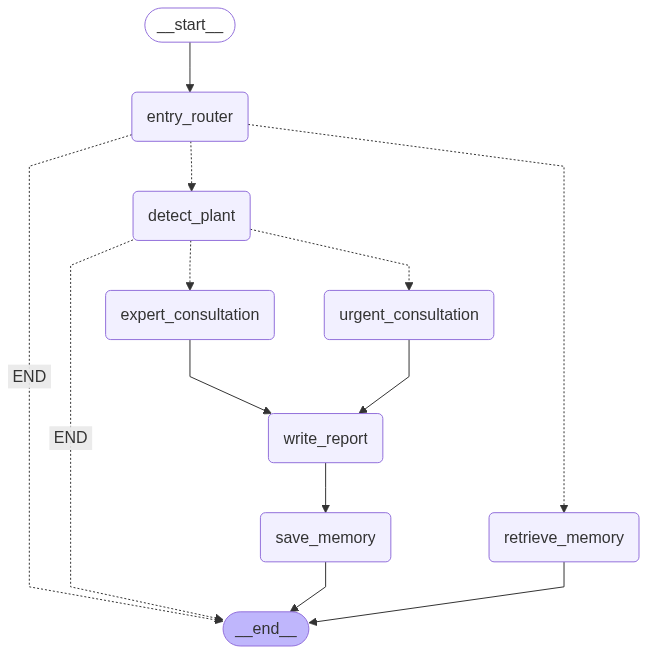

✅ Workflow graph saved as 'enhanced_plant_workflow.png'
🎯 Shows: Detection → Router → [Urgent/Expert] Consultation → Report


In [13]:
# Initialize the workflow
langgraph_workflow = create_plant_workflow()

if langgraph_workflow is None:
    print("❌ Workflow creation failed!")
else:
    print("✅ LangGraph MCP Workflow created with all tools")

def visualize_enhanced_workflow():
    """Generate and display enhanced workflow graph"""
    try:
        # Check if workflow exists
        if langgraph_workflow is None:
            print("❌ Cannot visualize: workflow is None")
            return
            
        from IPython.display import Image, display
        from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
        
        # Use the already created workflow
        display(Image(langgraph_workflow.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            wrap_label_n_words=6,
            draw_method=MermaidDrawMethod.API,
            background_color="white",
            padding=25,
            output_file_path="enhanced_plant_workflow.png"
        )))
        
        print("✅ Workflow graph saved as 'enhanced_plant_workflow.png'")
        print("🎯 Shows: Detection → Router → [Urgent/Expert] Consultation → Report")
        
    except Exception as e:
        print(f"❌ Graph generation failed: {e}")

# Generate visualization AFTER workflow is created
if langgraph_workflow is not None:
    print("🎨 Generating workflow visualization...")
    visualize_enhanced_workflow()
else:
    print("❌ Skipping visualization - workflow creation failed")


# Prep Runtime agent

In [14]:
# Create project folder
project_folder = "plant_agent_runtime"
os.makedirs(project_folder, exist_ok=True)

print(f"✅ Created folder: {project_folder}")

# Create __init__.py file
init_content = '''"""
Plant Analysis Agent - LangGraph MCP Workflow with Memory
"""

__version__ = "1.0.0"
__author__ = "Plant Health Team"
'''

with open(f"{project_folder}/__init__.py", 'w') as f:
    f.write(init_content)

print("✅ Created __init__.py")

# Copy requirements.txt
files_to_copy = ['requirements.txt']

for file_name in files_to_copy:
    if os.path.exists(file_name):
        shutil.copy(file_name, f"{project_folder}/{file_name}")
        print(f"✅ Copied: {file_name}")
    else:
        print(f"❌ Not found: {file_name}")
        

✅ Created folder: plant_agent_runtime
✅ Created __init__.py
✅ Copied: requirements.txt


In [15]:

with open('plant_gateway_config.json', 'r') as f:
    config = json.load(f)

workflow_code = f'''
# plant_workflow_memory.py - Complete LangGraph MCP Workflow with Memory
import os
import sys
import time
import logging
import boto3
import string
from datetime import datetime
import requests
import json
from typing import List, TypedDict, Any
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from bedrock_agentcore.runtime import BedrockAgentCoreApp
from bedrock_agentcore.memory import MemoryClient
from botocore.exceptions import ClientError
import random
import nest_asyncio
import base64

from bedrock_agentcore_starter_toolkit.operations.gateway.client import GatewayClient

nest_asyncio.apply()

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
logger = logging.getLogger("agentcore-memory")


# Create unique memory name with timestamp
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
unique_memory_name = f"PlantHealthAdvisor_{{timestamp}}"


# Initialize AgentCore App
app = BedrockAgentCoreApp()


# Load configuration
try:
   
    
    COGNITO_INFO = {config['COGNITO_INFO']}
    REGION = '{config.get('REGION')}'
    GATEWAY_ID = '{config['GATEWAY_ID']}'
    MEMORY_ROLE_ARN = '{config['MEMORY_ROLE_ARN']}'

    # setup the client
    client = GatewayClient(region_name=REGION)
    
    
    print("✅ Configuration loaded successfully!")
    print(f"Gateway ID: {{GATEWAY_ID}}")
    print(f"Region: {{REGION}}")
    
except FileNotFoundError:
    print("❌ Config file not found. Run the setup notebook first!")
    # Fallback to manual input
    REGION = input("Enter the AWS region: ")
    GATEWAY_ID = input("Enter Gateway ID: ")

MCP_URL = '{config['GATEWAY_URL']}'

# Memory configuration
MEMORY_REGION = '{config['REGION']}'
ACTOR_ID = "user_123"
SESSION_ID = "plant_analysis_session_001"  # Reuse same session for continuity

# Debug info that will be included in responses
MEMORY_DEBUG = {{
    "memory_name": unique_memory_name,
    "memory_region": MEMORY_REGION,
    "memory_role_arn": MEMORY_ROLE_ARN,
    "actor_id": ACTOR_ID,
    "session_id": SESSION_ID,
    "creation_attempt": False,
    "creation_success": False,
    "memory_id": None,
    "error_details": None
}}

# Initialize memory client and create memory
try:
    print(f"Initializing memory client for region: {{MEMORY_REGION}}")
    memory_client = MemoryClient(region_name=MEMORY_REGION)
    MEMORY_DEBUG["client_initialized"] = True
    
    print(f"Creating Memory with name: {{unique_memory_name}}")
    print(f"Using role ARN: {{MEMORY_ROLE_ARN}}")
    MEMORY_DEBUG["creation_attempt"] = True
    
    memory = memory_client.create_memory_and_wait(
        name=unique_memory_name,
        description="Plant Health Analysis Memory - Docker Container",
        strategies=[],
        event_expiry_days=30,
        memory_execution_role_arn=MEMORY_ROLE_ARN,
        max_wait=300,
        poll_interval=10
    )

    
    MEMORY_ID = memory['memoryId']
    print(f"✅ Memory created successfully with ID: {{MEMORY_ID}}")
    MEMORY_DEBUG["creation_success"] = True
    MEMORY_DEBUG["memory_id"] = MEMORY_ID
    print(f"✅ Memory created successfully with ID: {{MEMORY_ID}}")
    
except ClientError as e:
    MEMORY_DEBUG["client_error"] = str(e)
    MEMORY_DEBUG["error_code"] = e.response.get('Error', {{}}).get('Code', 'Unknown')
    
    if e.response['Error']['Code'] == 'ValidationException' and "already exists" in str(e):
        try:
            memories = memory_client.list_memories()
            MEMORY_ID = next((m['id'] for m in memories if m['id'].startswith(unique_memory_name)), None)
            MEMORY_DEBUG["found_existing"] = True
            MEMORY_DEBUG["memory_id"] = MEMORY_ID
            print(f"✅ Memory already exists. Using existing memory ID: {{MEMORY_ID}}")
        except Exception as list_error:
            MEMORY_DEBUG["list_error"] = str(list_error)
            MEMORY_ID = None
    else:
        print(f"❌ Memory creation error: {{e}}")
        MEMORY_DEBUG["error_details"] = str(e)
        MEMORY_ID = None
        
except Exception as e:
    print(f"❌ Memory ERROR: {{e}}")
    MEMORY_DEBUG["general_error"] = str(e)
    memory_client = None
    MEMORY_ID = None

# Add debug info to startup message
print(f"🧠 Memory Debug Info: {{MEMORY_DEBUG}}")

# Get access token
access_token = client.get_access_token_for_cognito(COGNITO_INFO)


def parse_mcp_response(result):
    """Parse nested MCP response"""
    try:
        if 'result' in result and 'content' in result['result']:
            content = result['result']['content'][0]['text']
            outer_json = json.loads(content)
            if 'response' in outer_json and 'payload' in outer_json['response']:
                body = outer_json['response']['payload']['body']
                return json.loads(body)
        return None
    except Exception as e:
        print(f"Parse error: {{e}}")
        return None

class PlantAnalysisState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    prompt: str           # For history detection
    query_type: str       # "analysis" or "history"
    image_path: str
    image_data: str
    plant_detection: dict
    health_issues: str
    expert_advice: str
    web_search_results: str
    final_report: str
    memory_status: str    # For memory operations

def call_mcp_tool(tool_name: str, arguments: dict, bearer_token: str):
    """Generic MCP tool caller"""
    headers = {{'Content-Type': 'application/json', 'Authorization': f'Bearer {{bearer_token}}'}}
    payload = {{
        "jsonrpc": "2.0",
        "id": 3,
        "method": "tools/call",
        "params": {{"name": tool_name, "arguments": arguments}}
    }}
    response = requests.post(MCP_URL, headers=headers, json=payload)
    return response.json()

def create_plant_workflow():
    """Create plant analysis workflow with memory integration"""
    workflow = StateGraph(PlantAnalysisState)
    
    def detect_plant(state: PlantAnalysisState) -> dict:
        """Plant detection using MCP gateway tool"""
        bearer_token = client.get_access_token_for_cognito(COGNITO_INFO)

        image_path = state.get('image_path', '')
        image_data = state.get('image_data', '')
        print(f"🔍 Starting plant detection for: {{image_path}}")

        try: 
            if image_data:
                print(f"✅ Using provided image_data: {{len(image_data)}} characters")
                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {{
                    "image_data": image_data
                }}, bearer_token)
            elif image_path and not image_path.startswith('s3://') and image_path != "from_image_data":
                if not os.path.exists(image_path):
                    print(f"❌ Image file not found: {{image_path}}")
                    return {{"plant_detection": {{"plant_type": "error"}}, "health_issues": "Image file not found"}}

                with open(image_path, 'rb') as f:
                    image_bytes = f.read()
                    image_data_encoded = base64.b64encode(image_bytes).decode('utf-8')
                    print(f"✅ Image encoded: {{len(image_data_encoded)}} characters")

                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {{
                    "image_data": image_data_encoded
                }}, bearer_token)
            else:
                result = call_mcp_tool("plant-detection-target___plant_detection_tool", {{
                    "image_path": image_path
                }}, bearer_token)

            parsed_result = parse_mcp_response(result)

            if parsed_result:
                plant_name = parsed_result.get("plant_name", "unknown")
                health_issues = parsed_result.get("health_issues", "")
                print(f"✅ Plant detected: {{plant_name}}")
                print(f"📋 Health status: {{health_issues}}")

                return {{
                    "plant_detection": {{"plant_type": plant_name}},
                    "health_issues": health_issues
                }}
        except Exception as e:
            print(f"❌ Plant detection error: {{e}}")

        return {{"plant_detection": {{"plant_type": "error"}}, "health_issues": "Detection failed"}}

    def entry_router(state: PlantAnalysisState) -> dict:
        """Route based on query type - history or plant analysis"""
        prompt = state.get("prompt", "")
        image_data = state.get("image_data", "")
        image_path = state.get("image_path", "")
        
        # Check for history keywords
        if prompt:
            history_keywords = ["show me", "previous", "compare", "history", "analyses", "month", "last time"]
            if any(keyword in prompt.lower() for keyword in history_keywords):
                return {{"next": "retrieve_memory"}}
        
        # If has image data, go to plant detection
        if image_data or image_path:
            return {{"next": "detect_plant"}}
        
        return {{"next": "END"}}
    # Analysis router for plant detection results
    def analysis_router(state: PlantAnalysisState) -> str:
        """Route based on plant detection results"""
        plant_detection = state.get("plant_detection", {{}})
        plant_name = plant_detection.get("plant_type", "").lower()
        health_issues = state.get("health_issues", "").lower()
        
        if not plant_name or plant_name == "error":
            return "END"
        
        # Check for critical issues
        critical_keywords = ["severe", "dying", "critical", "emergency"]
        if any(keyword in health_issues for keyword in critical_keywords):
            return "urgent_consultation"
        
        return "expert_consultation"

    def plant_care_agent(state: PlantAnalysisState) -> dict:
        """Plant care using MCP gateway tool"""
        bearer_token = client.get_access_token_for_cognito(COGNITO_INFO)


        plant_info = state.get('plant_detection', {{}})
        health_status = state.get('health_issues', '')
        plant_name = plant_info.get('plant_type', 'unknown plant')
        
        print(f"🌱 Getting care advice for: {{plant_name}}")
        print(f"📋 Health status: {{health_status}}")
        
        try:
            result = call_mcp_tool("plant-care-target___plant_care_tool", {{
                "plant_name": plant_name,
                "health_status": health_status
            }}, bearer_token)
            
            parsed_result = parse_mcp_response(result)
            
            if parsed_result and 'expert_advice' in parsed_result:
                advice = parsed_result['expert_advice']
                print(f"✅ Care advice received ({{len(advice)}} chars)")
                return {{'expert_advice': advice}}
                
        except Exception as e:
            print(f"❌ Plant care error: {{e}}")
        
        return {{'expert_advice': 'Plant care advice unavailable'}}

    def web_search_agent(state: PlantAnalysisState) -> dict:
        """Web search using MCP gateway tool"""
        bearer_token = client.get_access_token_for_cognito(COGNITO_INFO)


        plant_info = state.get('plant_detection', {{}})
        health_status = state.get('health_issues', '')
        plant_name = plant_info.get('plant_type', 'unknown plant')
        
        print(f"🔍 Web searching for: {{plant_name}}")
        
        try:
            result = call_mcp_tool("plant-web-search-target___plant_web_search_tool", {{
                "plant_name": plant_name,
                "health_status": health_status
            }}, bearer_token)
            
            parsed_result = parse_mcp_response(result)
            
            if parsed_result:
                search_results = parsed_result.get('web_search_results', str(parsed_result))
                print(f"✅ Web search completed ({{len(search_results)}} chars)")
                return {{'web_search_results': search_results}}
                
        except Exception as e:
            print(f"❌ Web search error: {{e}}")
        
        return {{'web_search_results': 'Web search unavailable'}}

    def expert_consultation_agent(state: PlantAnalysisState) -> dict:
        """Expert consultation with fallback to web search"""
        care_result = plant_care_agent(state)
        
        if care_result.get('expert_advice') and 'unavailable' not in care_result.get('expert_advice', ''):
            return care_result
        
        web_result = web_search_agent(state)
        return {{
            'expert_advice': web_result.get('web_search_results', 'No advice available'),
            'web_search_results': web_result.get('web_search_results', '')
        }}

    def urgent_consultation_agent(state: PlantAnalysisState) -> dict:
        """Urgent consultation - uses both care and web search"""
        care_result = plant_care_agent(state)
        web_result = web_search_agent(state)
        
        expert_advice = care_result.get('expert_advice', '')
        web_search_results = web_result.get('web_search_results', '')
        
        combined_advice = f"""**Expert Care Advice:**
{{expert_advice}}

**Additional Web Research:**
{{web_search_results}}"""
        
        return {{
            'expert_advice': combined_advice,
            'web_search_results': web_search_results
        }}
    
    def write_report(state: PlantAnalysisState) -> dict:
        """Generate final report"""
        plant_info = state.get("plant_detection", {{}})
        health_issues = state.get("health_issues", "")
        expert_advice = state.get("expert_advice", "")
        web_search_results = state.get("web_search_results", "")
        
        report = f"""# Plant Analysis Report

## Detection Results
- Plant Type: {{plant_info.get('plant_type', 'Unknown')}}
- Health Assessment: {{health_issues}}

## Expert Recommendations
{{expert_advice}}

## Analysis Method
- Source: MCP Gateway Tools
- Detection Tool: plant-detection-target___plant_detection_tool
- Care Tool: plant-care-target___plant_care_tool
- Search Tool: plant-web-search-target___plant_web_search_tool
"""
        
        return {{"final_report": report}}
    
    # Memory functions with FIXED actor_id and session_id
    def retrieve_memory_agent(state: PlantAnalysisState) -> dict:
        """Retrieve plant analysis history from memory"""
        debug_info = {{
        "memory_client_available": memory_client is not None,
        "memory_id": MEMORY_ID,
        "actor_id": ACTOR_ID,
        "session_id": SESSION_ID
    }}
        try:
            if not memory_client:
                return {{
                    "final_report": "# Memory Error\\n\\nMemory client not initialized",
                    "memory_status": "error"
                }}
                
            events = memory_client.list_events(
                memory_id=MEMORY_ID,
                actor_id=ACTOR_ID,
                session_id=SESSION_ID,
                max_results=10
            )
            debug_info["events_found"] = len(events)
            if events:
                history_summary = "# Plant Analysis History\\n\\n"
                for i, event in enumerate(events, 1):
                    history_summary += f"{{i}}. {{event}}\\n"
            else:
                history_summary = "# Plant Analysis History\\n\\nNo previous analyses found."
            
            return {{
                "final_report": history_summary,
                "memory_status": "retrieved"
            }}
        except Exception as e:
            return {{
                "final_report": f"# Memory Error\\n\\nCould not retrieve history: {{str(e)}}",
                "memory_status": "error"
            }}

    def save_memory_agent(state: PlantAnalysisState) -> dict:
        """Save plant analysis to memory after report generation"""
        debug_info = {{
        "memory_client_available": memory_client is not None,
        "memory_id": MEMORY_ID,
        "actor_id": ACTOR_ID,
        "session_id": SESSION_ID
    }}
        try:
            if not memory_client:
                print("⚠️ Memory client not available - continuing without memory")
                return {{
                    "final_report": state.get("final_report", "") + "\\n\\n*Memory not available*",
                    "memory_status": "error"
                }}
                
            plant_info = state.get("plant_detection", {{}})
            health_issues = state.get("health_issues", "")
            expert_advice = state.get("expert_advice", "")
            
            conversation = [
                (f"Plant analysis for {{plant_info.get('plant_type', 'unknown plant')}}", "USER"),
                (f"Plant: {{plant_info.get('plant_type')}}\\nHealth: {{health_issues}}\\nAdvice: {{expert_advice}}", "ASSISTANT")
            ]
            
            memory_client.save_conversation(
                memory_id=MEMORY_ID,
                actor_id=ACTOR_ID,
                session_id=SESSION_ID,
                messages=conversation
            )
            debug_info["save_successful"] = True
            current_report = state.get("final_report", "")
            enhanced_report = current_report + "\\n\\n*Analysis saved to memory for future reference*"
            
            return {{
                "final_report": enhanced_report,
                "memory_status": "saved"
            }}
        except Exception as e:
            current_report = state.get("final_report", "")
            enhanced_report = current_report + f"\\n\\n*Memory save failed: {{str(e)}}*"
            print(f"⚠️ Memory operation failed: {{e}} - continuing without memory")
            return {{
                "final_report": enhanced_report,
                "memory_status": f"save_failed: {{str(e)}}"
            }}

    # Add all nodes
    workflow.add_node("entry_router", entry_router)
    workflow.add_node("detect_plant", detect_plant)
    workflow.add_node("urgent_consultation", urgent_consultation_agent)
    workflow.add_node("expert_consultation", expert_consultation_agent)
    workflow.add_node("write_report", write_report)
    workflow.add_node("retrieve_memory", retrieve_memory_agent)
    workflow.add_node("save_memory", save_memory_agent)
    
    # Build workflow with TWO routers
    workflow.set_entry_point("entry_router")  # Start with entry router

    # Fix for conditional edges - extract the "next" key from the router's return value
    # Then use it directly in conditional edges
    workflow.add_conditional_edges(
        "entry_router",
        lambda state: state["next"],  # ❌ This looks for "next" in workflow state
        {{
            "detect_plant": "detect_plant",
            "retrieve_memory": "retrieve_memory",
            "END": END
        }}
    )
    # Analysis router edges (after plant detection)
    workflow.add_conditional_edges(
        "detect_plant",
        analysis_router,  # Your original router logic
        {{
            "urgent_consultation": "urgent_consultation",
            "expert_consultation": "expert_consultation",
            "END": END
        }}
    )
    
    # Analysis completion paths
    workflow.add_edge("expert_consultation", "write_report")
    workflow.add_edge("urgent_consultation", "write_report")
    workflow.add_edge("write_report", "save_memory")
    workflow.add_edge("save_memory", END)
    
    # History path
    workflow.add_edge("retrieve_memory", END)
    
    return workflow.compile(checkpointer=MemorySaver())

# Initialize the workflow
langgraph_workflow = create_plant_workflow()

@app.entrypoint
def invoke(payload):
    """AgentCore entrypoint for LangGraph MCP workflow with memory support"""
    # Truncate image_data for cleaner logging
    log_payload = payload.copy()
    if 'image_data' in log_payload and log_payload['image_data']:
        log_payload['image_data'] = f"{{log_payload['image_data'][:50]}}... ({{len(log_payload['image_data'])}} chars)"
    
    print(f"📥 Received payload: {{log_payload}}")
    
    prompt = payload.get("prompt", "")
    image_path = payload.get("image_path", "")
    image_data = payload.get("image_data", "")
    
    # Check if this is a history query
    history_keywords = ["show me", "previous", "compare", "history", "analyses", "month", "last time"]
    is_history_query = any(keyword in prompt.lower() for keyword in history_keywords) if prompt else False
    
    # Only require image for non-history queries
    if not is_history_query and not image_path and not image_data:
        return {{"error": "No image_path or image_data provided for plant analysis", "status": "failed"}}
    
    # Initialize state with all required fields
    initial_state = {{
        "messages": [],
        "prompt": prompt,
        "query_type": "history" if is_history_query else "analysis",
        "image_path": image_path or "from_image_data",
        "image_data": image_data,
        "plant_detection": {{}},
        "health_issues": "",
        "expert_advice": "",
        "web_search_results": "",
        "final_report": "",
        "memory_status": ""
    }}
    
    config = {{"configurable": {{"thread_id": f"agentcore_{{random.randint(1000, 9999)}}"}}}}
    
    try:
        final_state = langgraph_workflow.invoke(initial_state, config)
        
        return {{
            "plant_type": final_state.get('plant_detection', {{}}).get('plant_type', 'Unknown'),
            "health_issues": final_state.get('health_issues', ''),
            "expert_advice": final_state.get('expert_advice', ''),
            "web_search_results": final_state.get('web_search_results', ''),
            "final_report": final_state.get('final_report', ''),
            "memory_status": final_state.get('memory_status', ''),
            "debug_memory_id": MEMORY_ID,  # ADD: Debug info
            "debug_actor_id": ACTOR_ID,    # ADD: Debug info
            "debug_session_id": SESSION_ID, # ADD: Debug info
            "status": "success"
        }}
        
    except Exception as e:
        print(f"Workflow error: {{str(e)}}")
        return {{"error": str(e), "status": "failed"}}

print("✅ Enhanced LangGraph MCP Workflow with Memory created")

# Add this to make it runnable
if __name__ == "__main__":
    print("🚀 Starting Plant Analysis Agent...")
    print(f"🔗 Gateway: {{GATEWAY_ID}}")
    print(f"🌐 MCP URL: {{MCP_URL}}")
    print(f"🧠 Memory ID: {{MEMORY_ID}}")
    print(f"👤 Actor ID: {{ACTOR_ID}}")
    print(f"📝 Session ID: {{SESSION_ID}}")
    app.run()
'''

with open(f'{project_folder}/plant_workflow_memory.py', 'w') as f:
    f.write(workflow_code)

print("✅ Workflow saved to 'plant_workflow_memory.py'")
print("📝 Remember to update the configuration values in the file!")


✅ Workflow saved to 'plant_workflow_memory_new.py'
📝 Remember to update the configuration values in the file!


# Deploy using Starter toolkit

In [26]:
# Initialize
runtime = Runtime()

# Remove old config if it exists
try:
    config_path = runtime._config_path
    if os.path.exists(config_path):
        os.remove(config_path)
        print("✅ Removed old configuration")
except:
    pass

# Configure agent
config = runtime.configure(
    entrypoint=f'{project_folder}/plant_workflow_memory.py',
    requirements_file=f'{project_folder}/requirements.txt',
    agent_name="plant_advisor_agent",
    auto_create_ecr=True,
    disable_otel=True,
    execution_role=agentcore_iam_role['Role']['Arn']
)

Entrypoint parsed: file=/home/ec2-user/SageMaker/zBedrockAgentCore_Plant/plant_agent_runtime/plant_workflow_memory.py, bedrock_agentcore_name=plant_workflow_memory
2025-08-07 22:05:14 - INFO - Entrypoint parsed: file=/home/ec2-user/SageMaker/zBedrockAgentCore_Plant/plant_agent_runtime/plant_workflow_memory.py, bedrock_agentcore_name=plant_workflow_memory
Configuring BedrockAgentCore agent: plant_advisor_agent
2025-08-07 22:05:14 - INFO - Configuring BedrockAgentCore agent: plant_advisor_agent


⚠️  [WARNING] Platform mismatch: Current system is 'linux/amd64' but Bedrock AgentCore requires 'linux/arm64'.
For deployment options and workarounds, see: 
https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/getting-started-custom.html

Generated Dockerfile: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/Dockerfile
2025-08-07 22:05:14 - INFO - Generated Dockerfile: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/Dockerfile
Generated .dockerignore: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/.dockerignore
2025-08-07 22:05:14 - INFO - Generated .dockerignore: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/.dockerignore
Keeping 'plant_advisor_agent' as default agent
2025-08-07 22:05:14 - INFO - Keeping 'plant_advisor_agent' as default agent
Bedrock AgentCore configured: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/.bedrock_agentcore.yaml
2025-08-07 22:05:14 - INFO - Bedrock AgentCore configured: /home/ec2-user/SageMaker/zBedrockAgentCore_Plant/.bedrock_agentcore.yaml


In [27]:
# Launch 
runtime.launch()


🚀 CodeBuild mode: building in cloud (RECOMMENDED - DEFAULT)
2025-08-07 22:05:19 - INFO - 🚀 CodeBuild mode: building in cloud (RECOMMENDED - DEFAULT)
   • Build ARM64 containers in the cloud with CodeBuild
2025-08-07 22:05:19 - INFO -    • Build ARM64 containers in the cloud with CodeBuild
   • No local Docker required
2025-08-07 22:05:19 - INFO -    • No local Docker required
💡 Available deployment modes:
2025-08-07 22:05:19 - INFO - 💡 Available deployment modes:
   • runtime.launch()                           → CodeBuild (current)
2025-08-07 22:05:19 - INFO -    • runtime.launch()                           → CodeBuild (current)
   • runtime.launch(local=True)                 → Local development
2025-08-07 22:05:19 - INFO -    • runtime.launch(local=True)                 → Local development
   • runtime.launch(local_build=True)           → Local build + cloud deploy (NEW)
2025-08-07 22:05:19 - INFO -    • runtime.launch(local_build=True)           → Local build + cloud deploy (NEW)
Sta

✅ Reusing existing ECR repository: 593512547852.dkr.ecr.us-west-2.amazonaws.com/bedrock-agentcore-plant_advisor_agent


✅ Execution role validation passed: arn:aws:iam::593512547852:role/agentcore-plant-advisor-agent-langgraph-role
2025-08-07 22:05:20 - INFO - ✅ Execution role validation passed: arn:aws:iam::593512547852:role/agentcore-plant-advisor-agent-langgraph-role
Preparing CodeBuild project and uploading source...
2025-08-07 22:05:20 - INFO - Preparing CodeBuild project and uploading source...
2025-08-07 22:05:20 - INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
Getting or creating CodeBuild execution role for agent: plant_advisor_agent
2025-08-07 22:05:20 - INFO - Getting or creating CodeBuild execution role for agent: plant_advisor_agent
Role name: AmazonBedrockAgentCoreSDKCodeBuild-us-west-2-e87352cde7
2025-08-07 22:05:20 - INFO - Role name: AmazonBedrockAgentCoreSDKCodeBuild-us-west-2-e87352cde7
Reusing existing CodeBuild execution role: arn:aws:iam::593512547852:role/AmazonBedrockAgentCoreSDKCodeBuild-us-west-2-e87352cde7
2025-08-07 22:05:20 - INFO - Reusing exist

LaunchResult(mode='codebuild', tag='bedrock_agentcore-plant_advisor_agent:latest', env_vars=None, port=None, runtime=None, ecr_uri='593512547852.dkr.ecr.us-west-2.amazonaws.com/bedrock-agentcore-plant_advisor_agent', agent_id='plant_advisor_agent-G4nrgZE0My', agent_arn='arn:aws:bedrock-agentcore:us-west-2:593512547852:runtime/plant_advisor_agent-G4nrgZE0My', codebuild_id='bedrock-agentcore-plant_advisor_agent-builder:c1c6973a-2734-427c-b272-6ceaa7db3337', build_output=None)

# Invoke runtime

In [32]:
def resize_image_for_payload(image_path, max_size_kb=1024):
    """Resize image to fit within payload limits"""
    
    # Open and resize image
    with Image.open(image_path) as img:
        # Convert to RGB if necessary
        if img.mode in ('RGBA', 'P'):
            img = img.convert('RGB')
        
        # Start with reasonable dimensions
        max_dimension = 800
        
        while True:
            # Resize maintaining aspect ratio
            img.thumbnail((max_dimension, max_dimension), Image.Resampling.LANCZOS)
            
            # Save to bytes
            img_byte_arr = io.BytesIO()
            img.save(img_byte_arr, format='JPEG', quality=85)
            img_bytes = img_byte_arr.getvalue()
            
            # Check base64 size
            base64_data = base64.b64encode(img_bytes).decode('utf-8')
            size_kb = len(base64_data) / 1024
            
            print(f"Resized to {img.size}, base64 size: {size_kb:.1f}KB")
            
            if size_kb <= max_size_kb or max_dimension <= 200:
                break
                
            max_dimension = int(max_dimension * 0.8)  # Reduce by 20%
    
    return base64_data


In [36]:

try:
    print('🚀 Testing Plant Agent Runtime with real image...')
    
    # Read, resized, and encode the image file

    resized_image_data = resize_image_for_payload('./sweet_potato_leaf.png')
    
    # Test with resized image
    test_payload = {
        'prompt': 'Analyze my plant',
        'image_data': resized_image_data
    }
    
    response = runtime.invoke(payload=test_payload)
    print(f'✅ Agent invocation successful!')
    print(f'📝 Response Content Type: {response.get("contentType")}')
    
    # Process response - FULL OUTPUT
    if response.get("contentType") == "application/json":
        content = []
        for chunk in response.get("response", []):
            content.append(chunk.decode('utf-8'))
        result = json.loads(''.join(content))
        
        print(f"\n🌱 COMPLETE Plant Analysis Results:")
        print("=" * 80)
        
        print(f"\n📋 Plant Type: {result.get('plant_type', 'Unknown')}")
        
        print(f"\n🔍 Health Assessment:")
        print(result.get('health_issues', 'None'))
        
        print(f"\n👨‍⚕️ Expert Advice:")
        print(result.get('expert_advice', 'No advice available'))
        
        if result.get('web_search_results'):
            print(f"\n🔍 Web Search Results:")
            print(result.get('web_search_results'))
        
        print(f"\n📄 Final Report:")
        print(result.get('final_report', 'No report available'))
        
        print(f"\n✅ Status: {result.get('status', 'Unknown')}")
        
        print("=" * 80)
    else:
        print(f"Raw response: {response}")
    
    print('\n🎉 Plant Agent Runtime working perfectly with real image data!')

except Exception as e:
    print(f'❌ Agent invocation failed: {e}')


Invoking BedrockAgentCore agent 'plant_advisor_agent' via cloud endpoint
2025-08-07 22:48:47 - INFO - Invoking BedrockAgentCore agent 'plant_advisor_agent' via cloud endpoint


🚀 Testing Plant Agent Runtime with real image...
Resized to (784, 800), base64 size: 127.7KB
✅ Agent invocation successful!
📝 Response Content Type: application/json

🌱 COMPLETE Plant Analysis Results:

📋 Plant Type: sweet_potato_leaf

🔍 Health Assessment:
The leaves of the sweet potato plant are predominantly green, indicating good chlorophyll content and healthy photosynthesis. There are no visible signs of yellowing, browning, or wilting, which suggests that the plant is not experiencing malnutrition or water stress. The leaves do not show any black spots, brown spots, or white spots that would indicate fungal, bacterial, or viral infections. There are no holes or signs of pest damage, such as insect bites or chewed edges. The overall condition of the plant appears robust and healthy, with no evident nutrient deficiencies or disease symptoms.

👨‍⚕️ Expert Advice:
### Care Advice for Sweet Potato Leaf (Predominantly Green, Healthy Condition)

Given the healthy condition of your sweet

In [47]:
import json
import re

def extract_clean_plant_analysis(response_data):
    """Extract clean, readable plant analysis"""
    
    response_bytes = response_data.get('response', [])
    full_response = b''.join(response_bytes).decode('utf-8')
    
    try:
        parsed_response = json.loads(full_response)
        final_report = parsed_response.get('final_report', '')
        
        # Extract plant analysis sections
        # Look for "Plant: ... Health: ... Advice: ..." patterns
        plant_analyses = []
        
        # Split by numbered entries
        entries = re.split(r'\d+\.\s*{', final_report)
        
        for entry in entries[1:]:  # Skip the first split part
            # Look for the text content within conversational data
            text_matches = re.findall(r"'text': '([^']*(?:\\.[^']*)*)'", entry)
            
            for text in text_matches:
                cleaned_text = text.replace('\\\\n', '\n').replace("\\'", "'")
                
                # Check if this looks like a plant analysis
                if 'Plant:' in cleaned_text and 'Health:' in cleaned_text:
                    # Split into sections
                    sections = cleaned_text.split('\n')
                    
                    plant_info = ""
                    health_info = ""
                    advice_info = ""
                    current_section = None
                    
                    for line in sections:
                        if line.startswith('Plant:'):
                            plant_info = line
                            current_section = 'plant'
                        elif line.startswith('Health:'):
                            health_info = line
                            current_section = 'health'
                        elif line.startswith('Advice:'):
                            advice_info = line
                            current_section = 'advice'
                        elif current_section == 'health' and line.strip():
                            health_info += "\n" + line
                        elif current_section == 'advice' and line.strip():
                            advice_info += "\n" + line
                    
                    if plant_info and health_info:
                        plant_analyses.append({
                            'plant': plant_info,
                            'health': health_info,
                            'advice': advice_info
                        })
        
        return plant_analyses
        
    except Exception as e:
        print(f"Error extracting analysis: {e}")
        return []




In [56]:
try:
    print('🚀 Testing Plant Agent Runtime memory...')
    
    # Testing memory
    test_payload = {
        'prompt': "Show me my previous plant analyses"
    }
    
    response = runtime.invoke(payload=test_payload)
    print(f'✅ Agent invocation successful!')
    print(f'📝 Response Content Type: {response.get("contentType")}')

    # Process response - FULL OUTPUT
    if response.get("contentType") == "application/json":


        # Extract the main content
        response_bytes = response['response']
        full_response = b''.join(response_bytes).decode('utf-8')
        parsed = json.loads(full_response)

        final_report= parsed.get('final_report')
        
        print("=== EXTRACTED CONTENT ===")
        print(f"Status: {parsed.get('status')}")
        print(f"Memory Status: {parsed.get('memory_status')}")
        print(f"\nFinal Report:\n{final_report}")

        
    print('\n🎉 Plant Agent Runtime working perfectly with memory!')

except Exception as e:
    print(f'❌ Agent invocation failed: {e}')


Invoking BedrockAgentCore agent 'plant_advisor_agent' via cloud endpoint
2025-08-07 23:25:12 - INFO - Invoking BedrockAgentCore agent 'plant_advisor_agent' via cloud endpoint


🚀 Testing Plant Agent Runtime memory...
✅ Agent invocation successful!
📝 Response Content Type: application/json
=== EXTRACTED CONTENT ===
Status: success
Memory Status: retrieved

Final Report:
# Plant Analysis History

1. {'memoryId': 'PlantHealthAdvisor_20250807224712-kyyaeDF43I', 'actorId': 'user_123', 'sessionId': 'plant_analysis_session_001', 'eventId': '0000001754606939000#6fd9afa8', 'eventTimestamp': datetime.datetime(2025, 8, 7, 22, 48, 59, tzinfo=tzlocal()), 'payload': [{'conversational': {'content': {'text': 'Plant analysis for sweet_potato_leaf'}, 'role': 'USER'}}, {'conversational': {'content': {'text': 'Plant: sweet_potato_leaf\nHealth: The leaves of the sweet potato plant are predominantly green, indicating good chlorophyll content and healthy photosynthesis. There are no visible signs of yellowing, browning, or wilting, which suggests that the plant is not experiencing malnutrition or water stress. The leaves do not show any black spots, brown spots, or white spots that

In [57]:
analyses = re.findall(r"'text': '(Plant: [^']*(?:\\'[^']*)*)'", final_report)

for i, analysis in enumerate(analyses, 1):
    clean_analysis = analysis.replace('\\n', '\n').replace("\\'", "'")
    print(f"🌱 ANALYSIS #{i}")
    print("-" * 50)
    print(clean_analysis)
    print("\n" + "=" * 50 + "\n")


🌱 ANALYSIS #1
--------------------------------------------------
Plant: sweet_potato_leaf
Health: The leaves of the sweet potato plant are predominantly green, indicating good chlorophyll content and healthy photosynthesis. There are no visible signs of yellowing, browning, or wilting, which suggests that the plant is not experiencing malnutrition or water stress. The leaves do not show any black spots, brown spots, or white spots that would indicate fungal, bacterial, or viral infections. There are no holes or signs of pest damage, such as insect bites or chewed edges. The overall condition of the plant appears robust and healthy, with no evident nutrient deficiencies or disease symptoms.
Advice: ### Care Advice for Sweet Potato Leaf (Predominantly Green, Healthy Condition)

Given the healthy condition of your sweet potato plant, here are some care tips to maintain its robust health:

#### 1. **Light Requirements**
- **Sunlight:** Sweet potato plants thrive in full sunlight. Ensure th